In [46]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [47]:
df = pd.read_csv('/content/CRWV_2025-05-02 00_00_00+00_00.csv')
df

,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-05-02 13:30:00.385066943+00:00,2025-05-02 13:30:00.385066943+00:00,10,2,20613,A,A,0,46.94,800,...,100,1,1,45.69,47.40,24,10,1,1,CRWV
1,2025-05-02 13:30:00.830134278+00:00,2025-05-02 13:30:00.830134278+00:00,10,2,20613,T,N,0,46.72,2,...,100,1,1,45.69,47.40,24,10,1,1,CRWV
2,2025-05-02 13:30:00.830134278+00:00,2025-05-02 13:30:00.830134278+00:00,10,2,20613,T,N,0,46.74,1,...,100,1,1,45.69,47.40,24,10,1,1,CRWV
3,2025-05-02 13:30:00.932151709+00:00,2025-05-02 13:30:00.932151709+00:00,10,2,20613,T,N,0,46.75,1,...,100,1,1,45.69,47.40,24,10,1,1,CRWV
4,2025-05-02 13:30:00.934279465+00:00,2025-05-02 13:30:00.934279465+00:00,10,2,20613,T,N,0,46.76,1,...,100,1,1,45.69,47.40,24,10,1,1,CRWV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130653,2025-05-02 19:59:59.623525399+00:00,2025-05-02 19:59:59.623525399+00:00,10,2,20613,C,B,3,51.51,500,...,1200,1,1,51.26,51.75,100,361,1,1,CRWV
130654,2025-05-02 19:59:59.841041056+00:00,2025-05-02 19:59:59.841041056+00:00,10,2,20613,A,B,2,51.53,341,...,1200,1,1,51.26,51.75,100,361,1,1,CRWV
130655,2025-05-02 19:59:59.841047598+00:00,2025-05-02 19:59:59.841047598+00:00,10,2,20613,A,A,1,51.62,341,...,1200,1,1,51.26,51.75,100,361,1,1,CRWV
130656,2025-05-02 19:59:59.901998916+00:00,2025-05-02 19:59:59.901998916+00:00,10,2,20613,C,B,0,51.55,1041,...,1200,1,1,51.24,51.75,3300,361,1,1,CRWV


In [48]:
df.shape

(130658, 74)

In [49]:
# Convert timestamp and extract minute
df['ts_event'] = pd.to_datetime(df['ts_event'])
df['minute'] = df['ts_event'].dt.floor('min')

In [50]:
df_filtered = df[['minute', 'action', 'side', 'price', 'size']]

In [51]:
results = []

In [52]:
for minute, group in df_filtered[df_filtered['action'] == 'A'].groupby('minute'):
    ask_book = group[group['side'] == 'A'].sort_values(by='price')
    ask_book = ask_book.groupby('price').agg({'size': 'sum'}).reset_index()
    if ask_book['size'].sum() >= 400:
        selected_minute = minute
        break

In [53]:
# Step 3: Simulate slippage at that minute
group = df_filtered[(df_filtered['minute'] == selected_minute) & (df_filtered['action'] == 'A')]
ask_book = group[group['side'] == 'A'].sort_values(by='price')
ask_book = ask_book.groupby('price').agg({'size': 'sum'}).reset_index()

In [54]:
order_sizes = [50, 100, 150, 200, 250, 300, 350]
slippages = []
mid_price = group['price'].mean()

In [55]:
for order_size in order_sizes:
    remaining = order_size
    total_cost = 0
    for price, size in zip(ask_book['price'], ask_book['size']):
        buy_size = min(remaining, size)
        total_cost += buy_size * price
        remaining -= buy_size
        if remaining <= 0:
            break
    if remaining > 0:
        continue
    avg_price = total_cost / order_size
    slippage = avg_price - mid_price
    slippages.append(slippage)

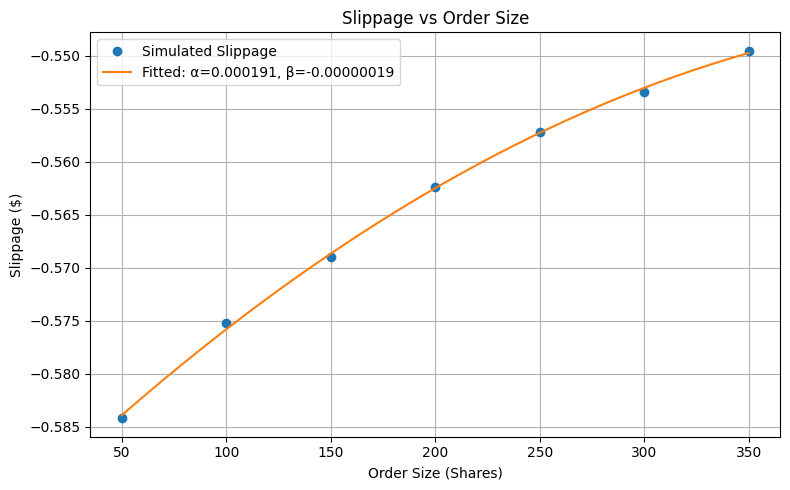

In [56]:
# Step 4: Fit and Plot
X = np.array(order_sizes[:len(slippages)])
y = np.array(slippages)
X_fit = np.column_stack((X, X**2))
model = LinearRegression().fit(X_fit, y)

x_plot = np.linspace(min(X), max(X), 100)
y_plot = model.predict(np.column_stack((x_plot, x_plot**2)))

plt.figure(figsize=(8, 5))
plt.plot(X, y, 'o', label='Simulated Slippage')
plt.plot(x_plot, y_plot, '-', label=f'Fitted: α={model.coef_[0]:.6f}, β={model.coef_[1]:.8f}')
plt.xlabel("Order Size (Shares)")
plt.ylabel("Slippage ($)")
plt.title("Slippage vs Order Size")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
X = np.array(order_sizes[:len(slippages)])
y = np.array(slippages)
X_design = np.column_stack((X, X**2))
model = LinearRegression().fit(X_design, y)

alpha = model.coef_[0]
beta = model.coef_[1]
gamma = model.intercept_

# Print final equation
print(f"Best fitting equation:")
print(f"Slippage(x) = {alpha:.6f}·x + {beta:.8f}·x² + {gamma:.6f}")

Best fitting equation:
Slippage(x) = 0.000191·x + -0.00000019·x² + -0.592991
